In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import QuantileTransformer


In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/人民币汇率收盘价Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
# 把date 变成 index 
sheet = sheet.set_index('Date')
last_day = sheet['人民币汇率收盘价Non-Trend/F0.2'].last_valid_index()
################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet.reset_index().rename(columns={'index':'Date'})

sheet = sheet

sheet.columns  


Index(['Date', '人民币汇率收盘价Non-Trend/F0.2', '金融机构外汇存款余额同比', '中国与美国10年国债利差',
       '美元指数', '人民币汇率/收盘-中间', 'SGX UC连1-连13'],
      dtype='object')

In [5]:
sheet.tail()

,Date,人民币汇率收盘价Non-Trend/F0.2,金融机构外汇存款余额同比,中国与美国10年国债利差,美元指数,人民币汇率/收盘-中间,SGX UC连1-连13
8774,2025-07-22,NaN,NaN,NaN,NaN,NaN,NaN
8775,2025-07-23,NaN,NaN,NaN,NaN,NaN,NaN
8776,2025-07-24,NaN,NaN,NaN,NaN,NaN,NaN
8777,2025-07-25,NaN,NaN,NaN,NaN,NaN,NaN
8778,2025-07-28,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sheet1 = pd.read_csv('data_output/美元指数_未来日度预测.csv')
sheet1.head()

,Date,美元指数_预测
0,2025-06-30,97.056832
1,2025-07-01,98.091971
2,2025-07-02,98.156997
3,2025-07-03,98.156670
4,2025-07-04,98.229548


In [7]:
sheet2 = pd.read_csv('data_output/中国10年期国债收益率_未来日度预测.csv')
sheet2.head()

,Date,中国10年期国债收益率
0,2025-07-01,1.653224
1,2025-07-02,1.638986
2,2025-07-03,1.636918
3,2025-07-04,1.614280
4,2025-07-07,1.615892


In [8]:
sheet3 = pd.read_csv('data_output/10年期美国国债收益率_未来日度预测.csv')
sheet3.head()

,Date,10年期美国国债收益率
0,2025-06-30,4.266017
1,2025-07-01,4.305664
2,2025-07-02,4.324851
3,2025-07-03,4.324769
4,2025-07-04,4.341113


In [9]:
# 确保 'Date' 列是 datetime 类型
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
# 计算中国与美国10年国债利差
sheet2['中国与美国10年国债利差'] = sheet2['中国10年期国债收益率'] - sheet3['10年期美国国债收益率']

# 将美元指数预测值添加到sheet中
sheet_usd = pd.merge(sheet, sheet1[['Date', '美元指数_预测']], how='outer', left_on='Date', right_on='Date')
sheet['美元指数'] = sheet_usd['美元指数'].combine_first(sheet_usd['美元指数_预测'])

# 将国债利差添加到sheet中
sheet_spread = pd.merge(sheet, sheet2[['Date', '中国与美国10年国债利差']], how='outer', left_on='Date', right_on='Date')
sheet['中国与美国10年国债利差'] = sheet_spread['中国与美国10年国债利差_x'].combine_first(sheet_spread['中国与美国10年国债利差_y'])


# 打印结果查看
sheet.tail()

,Date,人民币汇率收盘价Non-Trend/F0.2,金融机构外汇存款余额同比,中国与美国10年国债利差,美元指数,人民币汇率/收盘-中间,SGX UC连1-连13
8774,2025-07-22,NaN,NaN,-2.632731,97.333216,NaN,NaN
8775,2025-07-23,NaN,NaN,-2.713061,97.541448,NaN,NaN
8776,2025-07-24,NaN,NaN,-2.738181,97.750683,NaN,NaN
8777,2025-07-25,NaN,NaN,-2.716551,98.104837,NaN,NaN
8778,2025-07-28,NaN,NaN,-2.709480,98.017832,NaN,NaN


In [10]:
################################# 处理缺失值 #################################
'''
1. 因子进行填充
2. 用 Dtool 的 fill_missing_values 填充因子
'''
fill_methods = {
'金融机构外汇存款余额同比':'interpolate', 
'中国与美国10年国债利差':'interpolate', 
'美元指数':'interpolate',   
'人民币汇率/收盘-中间':'interpolate', 
'SGX UC连1-连13' :'interpolate'                            
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)

#################################  因子处理  #################################
# 领先性
sheet['金融机构外汇存款余额同比_提前20天'] = sheet['金融机构外汇存款余额同比'].shift(20)                      
sheet['中国与美国10年国债利差_提前20天'] = sheet['中国与美国10年国债利差'].shift(20)
sheet['美元指数_提前20天'] = sheet['美元指数'].shift(20)
sheet['人民币汇率/收盘-中间_提前20天'] = sheet['人民币汇率/收盘-中间'].shift(20)
sheet['SGX UC连1-连13_提前30天'] = sheet['SGX UC连1-连13'].shift(40)

# 逆序
sheet['金融机构外汇存款余额同比_提前20天_逆序'] = reverse_column(sheet, '金融机构外汇存款余额同比_提前20天')
sheet['中国与美国10年国债利差_提前20天_逆序'] = reverse_column(sheet, '中国与美国10年国债利差_提前20天')


'''
# 使用移动平均滤波

sheet['人民币汇率/收盘-中间_提前20天'] = sheet['人民币汇率/收盘-中间_提前20天'].rolling(window=5).mean()

# 使用指数加权移动平均滤波
sheet['人民币汇率/收盘-中间_提前20天_EMA5'] = sheet['人民币汇率/收盘-中间_提前20天'].ewm(span=5, adjust=False).mean()
sheet['人民币汇率/收盘-中间_提前20天_EMA10'] = sheet['人民币汇率/收盘-中间_提前20天'].ewm(span=10, adjust=False).mean()

# 使用低通滤波器 - 通过差分和平滑组合实现
sheet['人民币汇率/收盘-中间_提前20天_平滑'] = sheet['人民币汇率/收盘-中间_提前20天'].diff().fillna(0).rolling(window=3).mean().cumsum() + sheet['人民币汇率/收盘-中间_提前20天'].iloc[0]

'''

'''
# 以下代码属于因子工程部分，根据分布情况进行非线性变换
# 示例1：如果“全国观影人次/30DMA_提前25天”呈现严重右偏分布，则可以采用对数转换，将其数值差异放大
sheet['美国经济惊喜指数_提前56天_log'] = np.log1p(sheet['美国经济惊喜指数_提前56天'])

# 示例2：如果发现“中国服务业PMI/3MMA_提前30天”可以用平方转换来更好地表达数据特征，则可使用如下方法：
sheet['美国经济惊喜指数_提前56天_power'] = sheet['美国经济惊喜指数_提前56天'] ** 2

# 示例1：如果“全国观影人次/30DMA_提前25天”呈现严重右偏分布，则可以采用对数转换，将其数值差异放大
sheet['全国观影人次/30DMA_提前25天'] = np.log1p(sheet['全国观影人次/30DMA_提前25天'])

# 示例2：如果发现“中国服务业PMI/3MMA_提前30天”可以用平方转换来更好地表达数据特征，则可使用如下方法：
sheet['中国服务业PMI/3MMA_提前30天'] = sheet['中国服务业PMI/3MMA_提前30天'] ** 2
# np.sqrt(x) 计算 x 的平方根，适用于轻度右偏分布的数据
sheet['全国观影人次/30DMA_提前25天'] = np.sqrt(sheet['全国观影人次/30DMA_提前25天'])
# 1 / x 计算倒数，适用于有较大值的右偏数据
sheet['全国观影人次/30DMA_提前25天'] = 1 / sheet['全国观影人次/30DMA_提前25天']
# 对数据应用Box-Cox变换，确保数据为正数后进行变换
sheet['全国观影人次/30DMA_提前25天'] = sheet['全国观影人次/30DMA_提前25天'].apply(lambda x: max(x, 1e-5))  # 确保数据为正
sheet['全国观影人次/30DMA_提前25天'], _ = stats.boxcox(sheet['全国观影人次/30DMA_提前25天'])
# 备注: 适用于右偏分布数据，目标是将数据转换为更接近正态分布。
# np.exp(x) 对数据应用指数变换，适用于左偏分布数据
sheet['全国观影人次/30DMA_提前25天'] = np.exp(sheety['全国观影人次/30DMA_提前25天'])
# 备注: 适用于左偏数据或当数据呈现指数增长趋势时
# 对数据进行平方变换，适用于特征和目标之间有非线性关系的情况
sheet['全国观影人次/30DMA_提前25天'] = sheet['全国观影人次/30DMA_提前25天']**2  # 对数据进行平方变换
# 备注: 用于处理非线性关系，适合与目标变量之间有二次关系的数据。
# 将数据转换为标准正态分布或均匀分布
qt = QuantileTransformer(output_distribution='normal')  # 或 'uniform'
sheet['全国观影人次/30DMA_提前25天'] = qt.fit_transform(sheet[['全国观影人次/30DMA_提前25天']])
# 备注: 适用于非正态分布的特征，通过转换使数据服从标准正态分布或均匀分布。

'''
################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-02')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['人民币汇率收盘价Non-Trend/F0.2'].notna())   
]

################################# 数据 读取-处理 结束 #################################

In [11]:
sheet_daily.tail()

,Date,人民币汇率收盘价Non-Trend/F0.2,金融机构外汇存款余额同比,中国与美国10年国债利差,美元指数,人民币汇率/收盘-中间,SGX UC连1-连13,金融机构外汇存款余额同比_提前20天,中国与美国10年国债利差_提前20天,美元指数_提前20天,人民币汇率/收盘-中间_提前20天,SGX UC连1-连13_提前30天,金融机构外汇存款余额同比_提前20天_逆序,中国与美国10年国债利差_提前20天_逆序
677,2025-07-22,NaN,0.1897,-2.632731,97.333216,0.007,0.1737,0.1897,-2.6533,97.957200,0.0125,0.1852,0.3133,2.0034
678,2025-07-23,NaN,0.1897,-2.713061,97.541448,0.007,0.1737,0.1897,-2.6393,97.703200,0.0045,0.1837,0.3133,1.9894
679,2025-07-24,NaN,0.1897,-2.738181,97.750683,0.007,0.1737,0.1897,-2.6111,97.307700,0.0064,0.1820,0.3133,1.9612
680,2025-07-25,NaN,0.1897,-2.716551,98.104837,0.007,0.1737,0.1897,-2.6447,97.261600,0.0063,0.1803,0.3133,1.9948
681,2025-07-28,NaN,0.1897,-2.709480,98.017832,0.007,0.1737,0.1897,-2.6366,97.056832,0.0070,0.1843,0.3133,1.9867


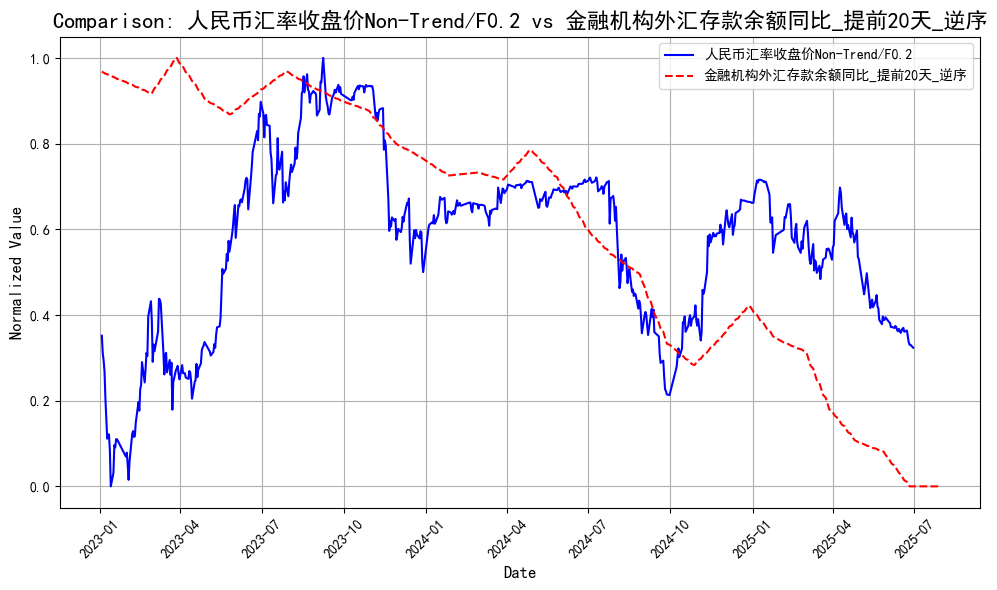

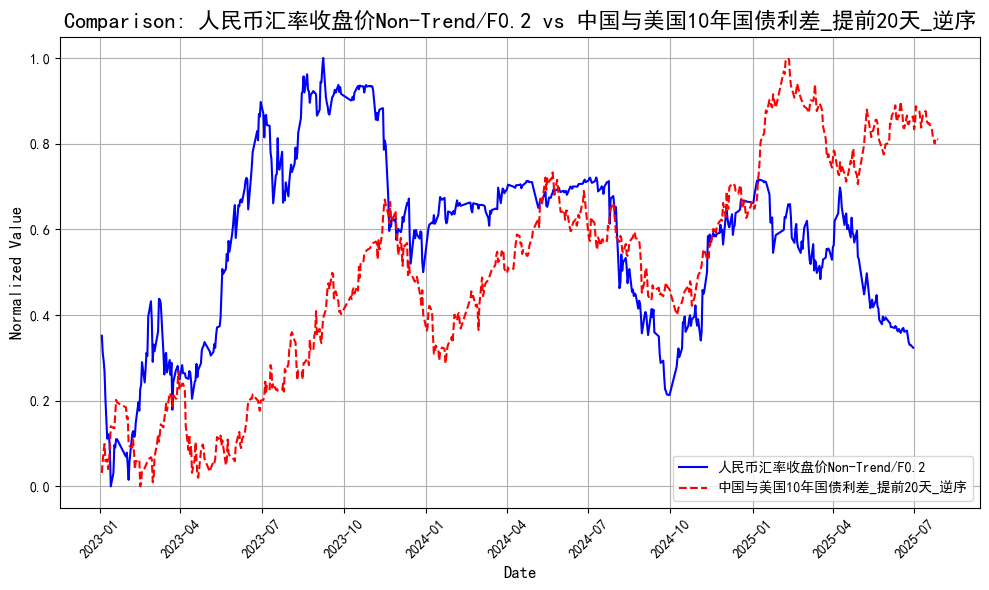

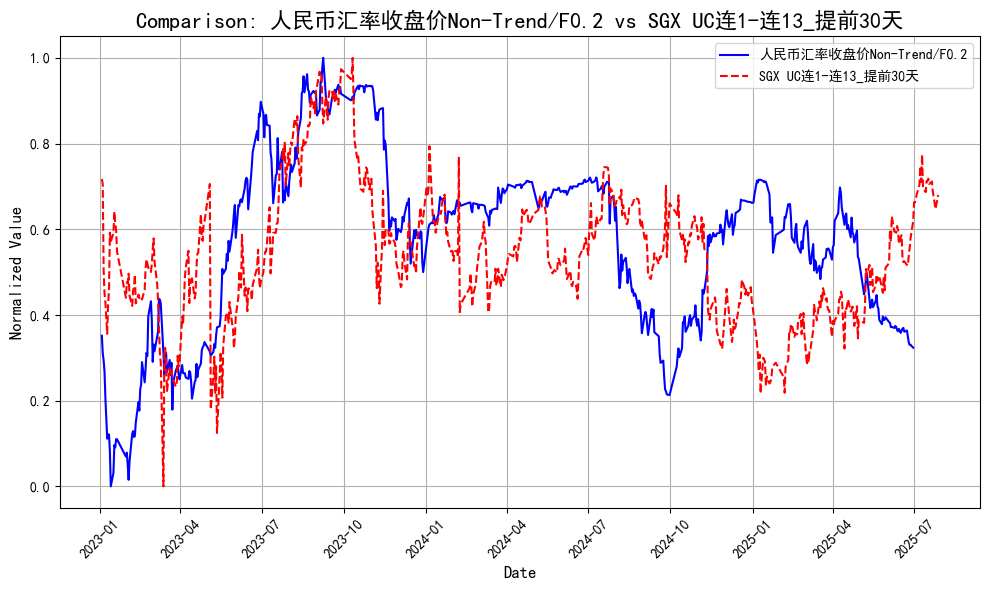

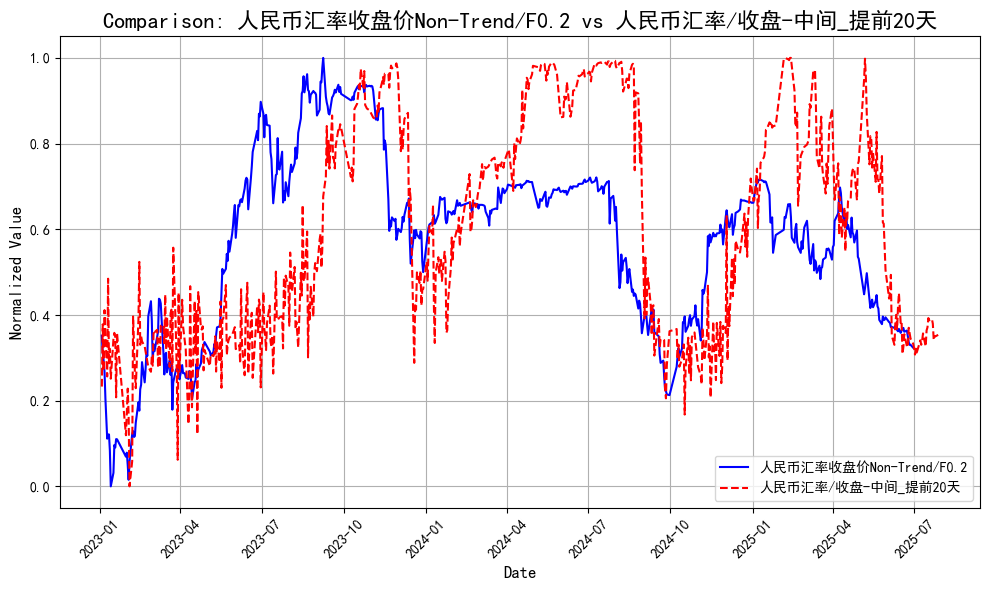

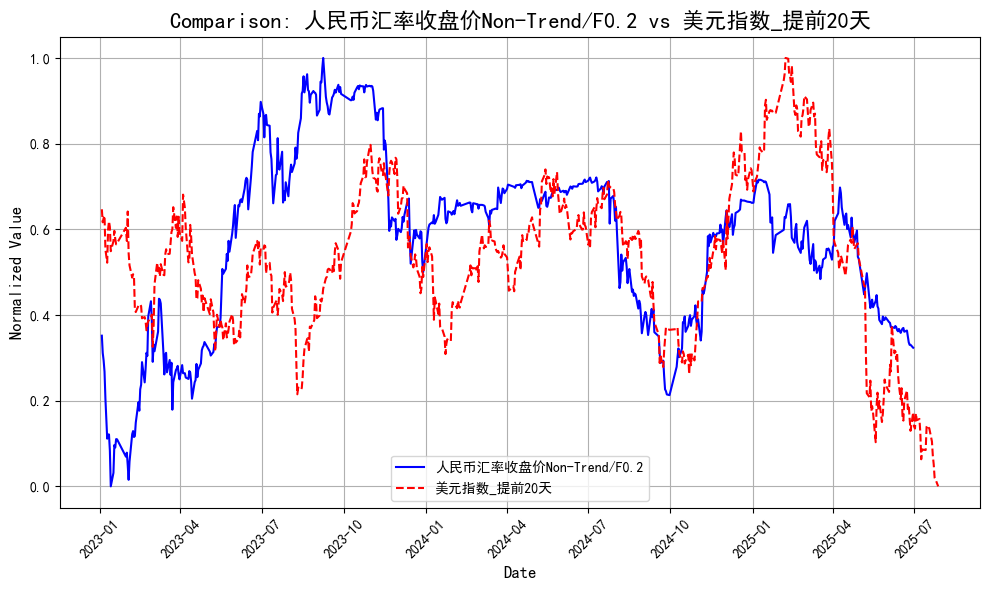

In [12]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='人民币汇率收盘价Non-Trend/F0.2', 
    compare_cols=[
       '金融机构外汇存款余额同比_提前20天_逆序',
       '中国与美国10年国债利差_提前20天_逆序',
       'SGX UC连1-连13_提前30天',
       '人民币汇率/收盘-中间_提前20天',
       '美元指数_提前20天'
       ]
)

In [13]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 因子集
feature_columns = [
    '金融机构外汇存款余额同比_提前20天_逆序'  ,
       '中国与美国10年国债利差_提前20天_逆序' ,
       'SGX UC连1-连13_提前30天',
       '人民币汇率/收盘-中间_提前20天',
       '美元指数_提前20天'
]
# 预测目标column
predict_column = '人民币汇率收盘价Non-Trend/F0.2'

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

'''
######################################## 因子权重调节 #################################
feature_weights_dict = {
    '全国观影人次/30DMA_提前25天': 100.0,
    # 如有其他因子需要特殊权重，可继续添加，例如:
    # '传统汽车销量12月移动平均同比_提前80天': 1.5,
}

# 初始化所有因子的权重为1（与 feature_columns 顺序一致）
feature_weights = np.ones(len(feature_columns))

# 根据字典更新指定因子的权重
for feature, weight in feature_weights_dict.items():
    if feature in feature_columns:
        idx = feature_columns.index(feature)
        feature_weights[idx] = weight

# 打印每个因子的权重，便于检查
for feature, weight in zip(feature_columns, feature_weights):
    print(f"{feature}: {weight}")

# 将权重应用到原始数据上（所有数据均乘以对应的权重）
for idx, feature in enumerate(feature_columns):
    weight = feature_weights[idx]
    X_train[feature] = X_train[feature] * weight
    X_test[feature] = X_test[feature] * weight
    X_future[feature] = X_future[feature] * weight
########################################################################################################################


######################################## 指定哪些因子 不需要 因子标准化 #################################

# 定义不进行标准化的因子列表（这里以‘全国观影人次/30DMA_提前25天’为例，可根据需要添加其他因子）
non_scaled_features = ['全国观影人次/30DMA_提前25天']

# 得到需要标准化的特征列表
scaled_features = [col for col in feature_columns if col not in non_scaled_features]

# 分别提取需要标准化的部分数据
X_train_to_scale = X_train[scaled_features]
X_test_to_scale = X_test[scaled_features]
X_future_to_scale = X_future[scaled_features]

# 初始化 StandardScaler 并对待标准化特征进行拟合和转换
scaler = StandardScaler()
X_train_scaled_part = scaler.fit_transform(X_train_to_scale)
X_test_scaled_part = scaler.transform(X_test_to_scale)
X_future_scaled_part = scaler.transform(X_future_to_scale)

# 将转换后的数据合并回原始 DataFrame，保证未标准化的因子保持原始数据
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_future_scaled = X_future.copy()

X_train_scaled.loc[:, scaled_features] = X_train_scaled_part
X_test_scaled.loc[:, scaled_features] = X_test_scaled_part
X_future_scaled.loc[:, scaled_features] = X_future_scaled_part
########################################################################################################################
'''

################################# Xgboost 模型 训练 测试 预测 #################################

# 正则化所有input 选择standard 因为金融数据 会超过过往极值的问题
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 创建DMatrix对象,设置样本权重以降低异常值的影响
train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.081,  # 较小的学习率
    'max_depth': 9,  # 控制树的深度防止过拟合
    'min_child_weight': 1,  # 控制过拟合
    'subsample': 0.9,  # 随机采样防止过拟合
    'colsample_bytree': 0.9,  # 特征随机采样
    'gamma': 0.001,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

# 训练模型，使用早停策略，最大训练轮数
num_boost_round = 100000
# 记录评估指标、存储
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)

# 训练集预测
y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
# 测试集预测
y_test_pred_dmatrix = model.predict(test_dmatrix)

# 计算 MSE 和 R² 分数
# 计算训练集和测试集的MSE
train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
# 计算训练集和测试集的R²
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
# 打印结果
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
# 测试预测 存储
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
# 未来预测 存储
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.12007	train-rmse:0.10424


[100]	eval-rmse:0.04606	train-rmse:0.01810
[200]	eval-rmse:0.04591	train-rmse:0.01797
[252]	eval-rmse:0.04593	train-rmse:0.01797
训练集 MSE (DMatrix): 0.0004, 训练集 R² (DMatrix): 0.9735
测试集 MSE (DMatrix): 0.0021, 测试集 R² (DMatrix): -8.8309


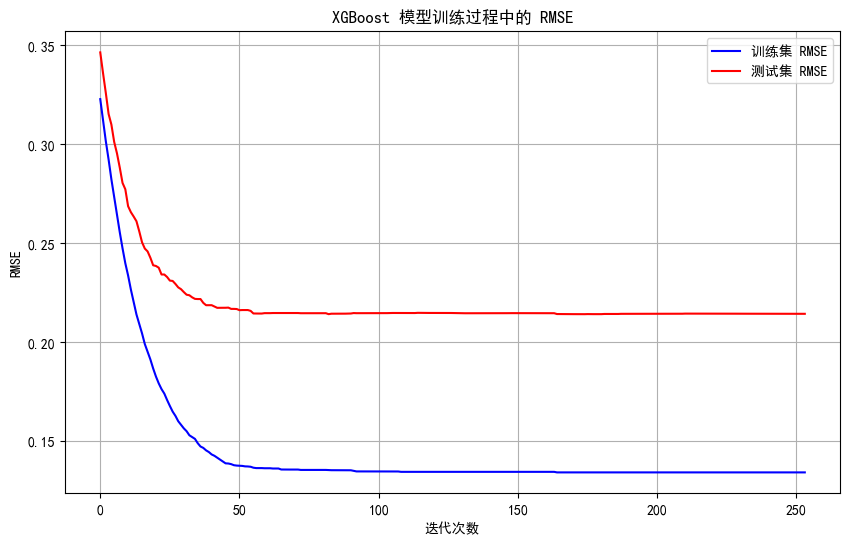

In [14]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 对所有数据进行标准化（使用之前拟合的 scaler）
X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)

# 对未来数据进行预测
y_future_pred_all = model_all.predict(future_dmatrix_all)

# 计算全部数据的 MSE 和 R² 分数
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred

# 存储未来预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:0.10427
[100]	train-rmse:0.01804
[200]	train-rmse:0.01797
[300]	train-rmse:0.01792
[400]	train-rmse:0.01790
[500]	train-rmse:0.01788
[600]	train-rmse:0.01787
[700]	train-rmse:0.01787
[719]	train-rmse:0.01787
全部数据 MSE: 0.0003, 全部数据 R²: 0.9744


In [16]:
'''
################################# 可视化 #################################
'''
# 蓝色：真实数据
# 绿色：训练集数据 预测 模型表现
# 紫色：测试集数据 预测 模型表现
# 红线：未来集数据 预测 正常预测 
# 黑线：未来集数据 预测 全部数据训练预测 
'''
# 创建一个新的图形
plt.figure(figsize=(30, 8))

# 训练集和测试集的连接点(预测值)
train_last_date = train_data['Date'].iloc[-1]
test_first_date = test_data['Date'].iloc[0]
train_last_value = y_train_pred_dmatrix[-1]
test_first_value = y_test_pred_dmatrix[0]

# 训练集和测试集的连接点(真实值)
train_last_date_real = train_data['Date'].iloc[-1]
test_first_date_real = test_data['Date'].iloc[0]
train_last_value_real = y_train.iloc[-1]
test_first_value_real = y_test.iloc[0]

# 测试集和未来集的连接点(普通预测)
test_last_date = test_data['Date'].iloc[-1]
future_first_date = future_data['Date'].iloc[0]
test_last_value = y_test_pred_dmatrix[-1]
future_first_value = future_data['预测值'].iloc[0]

# 测试集和未来集的连接点(全量预测)
test_last_date_all = test_data['Date'].iloc[-1]
future_first_date_all = future_data['Date'].iloc[0]
test_last_value_all = y_test.iloc[-1]
future_first_value_all = future_data['预测值_全量'].iloc[0]

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加连接线
plt.plot([train_last_date, test_first_date], [train_last_value, test_first_value], color='purple')
plt.plot([test_last_date, future_first_date], [test_last_value, future_first_value], color='red')
plt.plot([train_last_date_real, test_first_date_real], [train_last_value_real, test_first_value_real], color='blue')
plt.plot([test_last_date_all, future_first_date_all], [test_last_value_all, future_first_value_all], color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n# 创建一个新的图形\nplt.figure(figsize=(30, 8))\n\n# 训练集和测试集的连接点(预测值)\ntrain_last_date = train_data['Date'].iloc[-1]\ntest_first_date = test_data['Date'].iloc[0]\ntrain_last_value = y_train_pred_dmatrix[-1]\ntest_first_value = y_test_pred_dmatrix[0]\n\n# 训练集和测试集的连接点(真实值)\ntrain_last_date_real = train_data['Date'].iloc[-1]\ntest_first_date_real = test_data['Date'].iloc[0]\ntrain_last_value_real = y_train.iloc[-1]\ntest_first_value_real = y_test.iloc[0]\n\n# 测试集和未来集的连接点(普通预测)\ntest_last_date = test_data['Date'].iloc[-1]\nfuture_first_date = future_data['Date'].iloc[0]\ntest_last_value = y_test_pred_dmatrix[-1]\nfuture_first_value = future_data['预测值'].iloc[0]\n\n# 测试集和未来集的连接点(全量预测)\ntest_last_date_all = test_data['Date'].iloc[-1]\nfuture_first_date_all = future_data['Date'].iloc[0]\ntest_last_value_all = y_test.iloc[-1]\nfuture_first_value_all = future_data['预测值_全量'].iloc[0]\n\n# 绘制主要数据\nplt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')\nplt.plot(train_data['Date'], y_train_

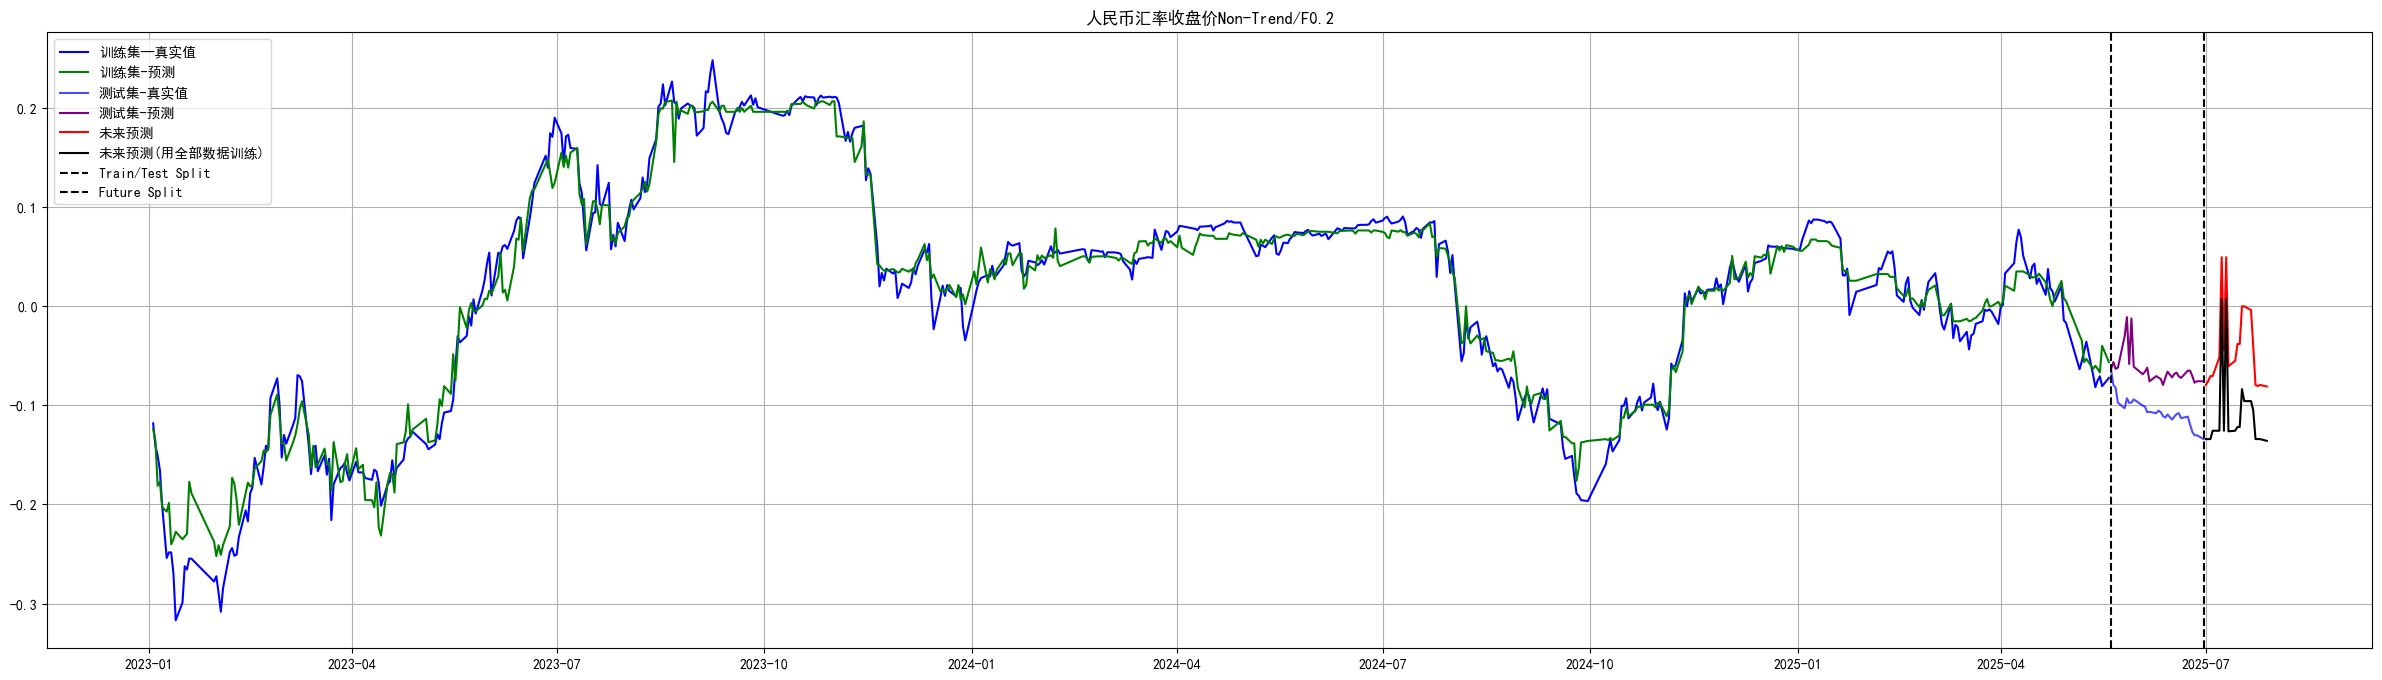

In [17]:

################################# 可视化 #################################

# 蓝色：真实数据
# 绿色：训练集数据 预测 模型表现
# 紫色：测试集数据 预测 模型表现
# 红线：未来集数据 预测 正常预测 
# 黑线：未来集数据 预测 全部数据训练预测 


# 创建一个新的图形
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('人民币汇率收盘价Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()



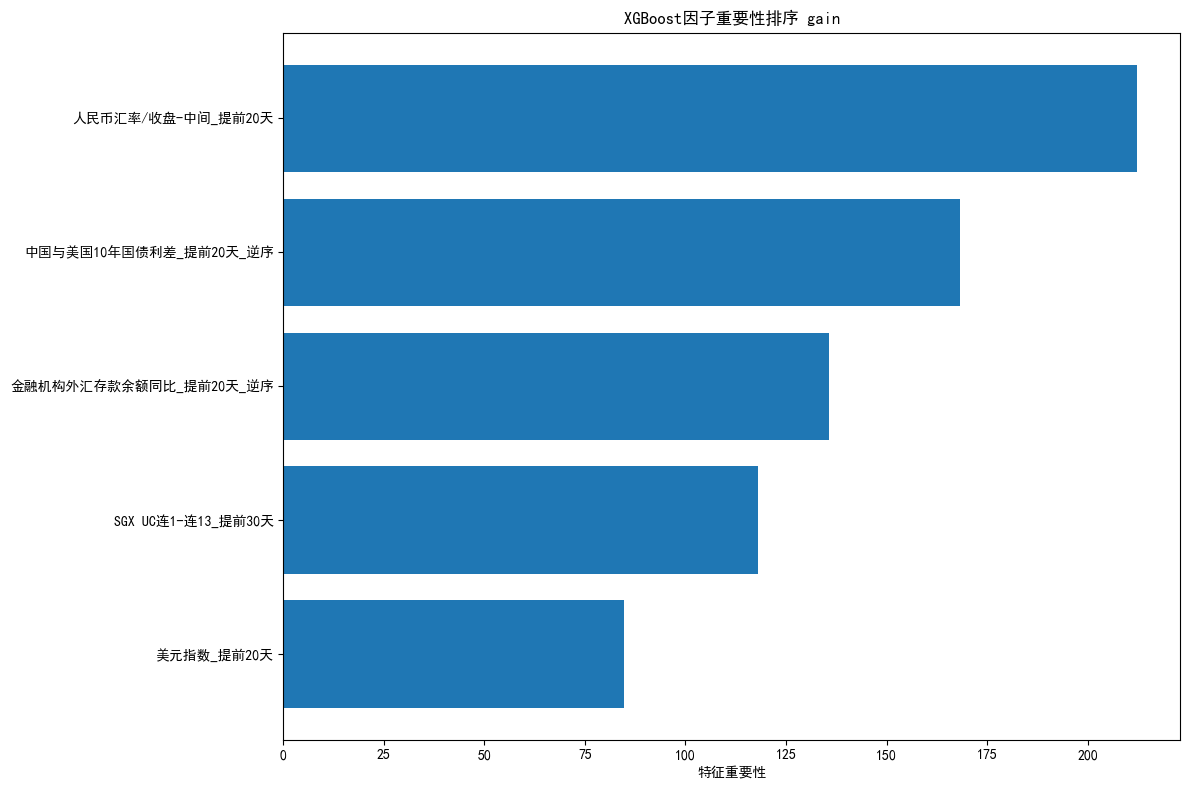

In [18]:

# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'cover'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()


---

In [19]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并历史真实值和预测值
merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/人民币汇率收盘价Non-Trend_F0.2_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily 

,Date,真实值,预测值
624,2025/07/28,NaN,-0.135873
623,2025/07/25,NaN,-0.134100
622,2025/07/24,NaN,-0.134100
621,2025/07/23,NaN,-0.134100
620,2025/07/22,NaN,-0.105186
...,...,...,...
4,2023/01/07,-0.2013,NaN
3,2023/01/06,-0.1656,NaN
2,2023/01/05,-0.1509,NaN
1,2023/01/04,-0.1411,NaN


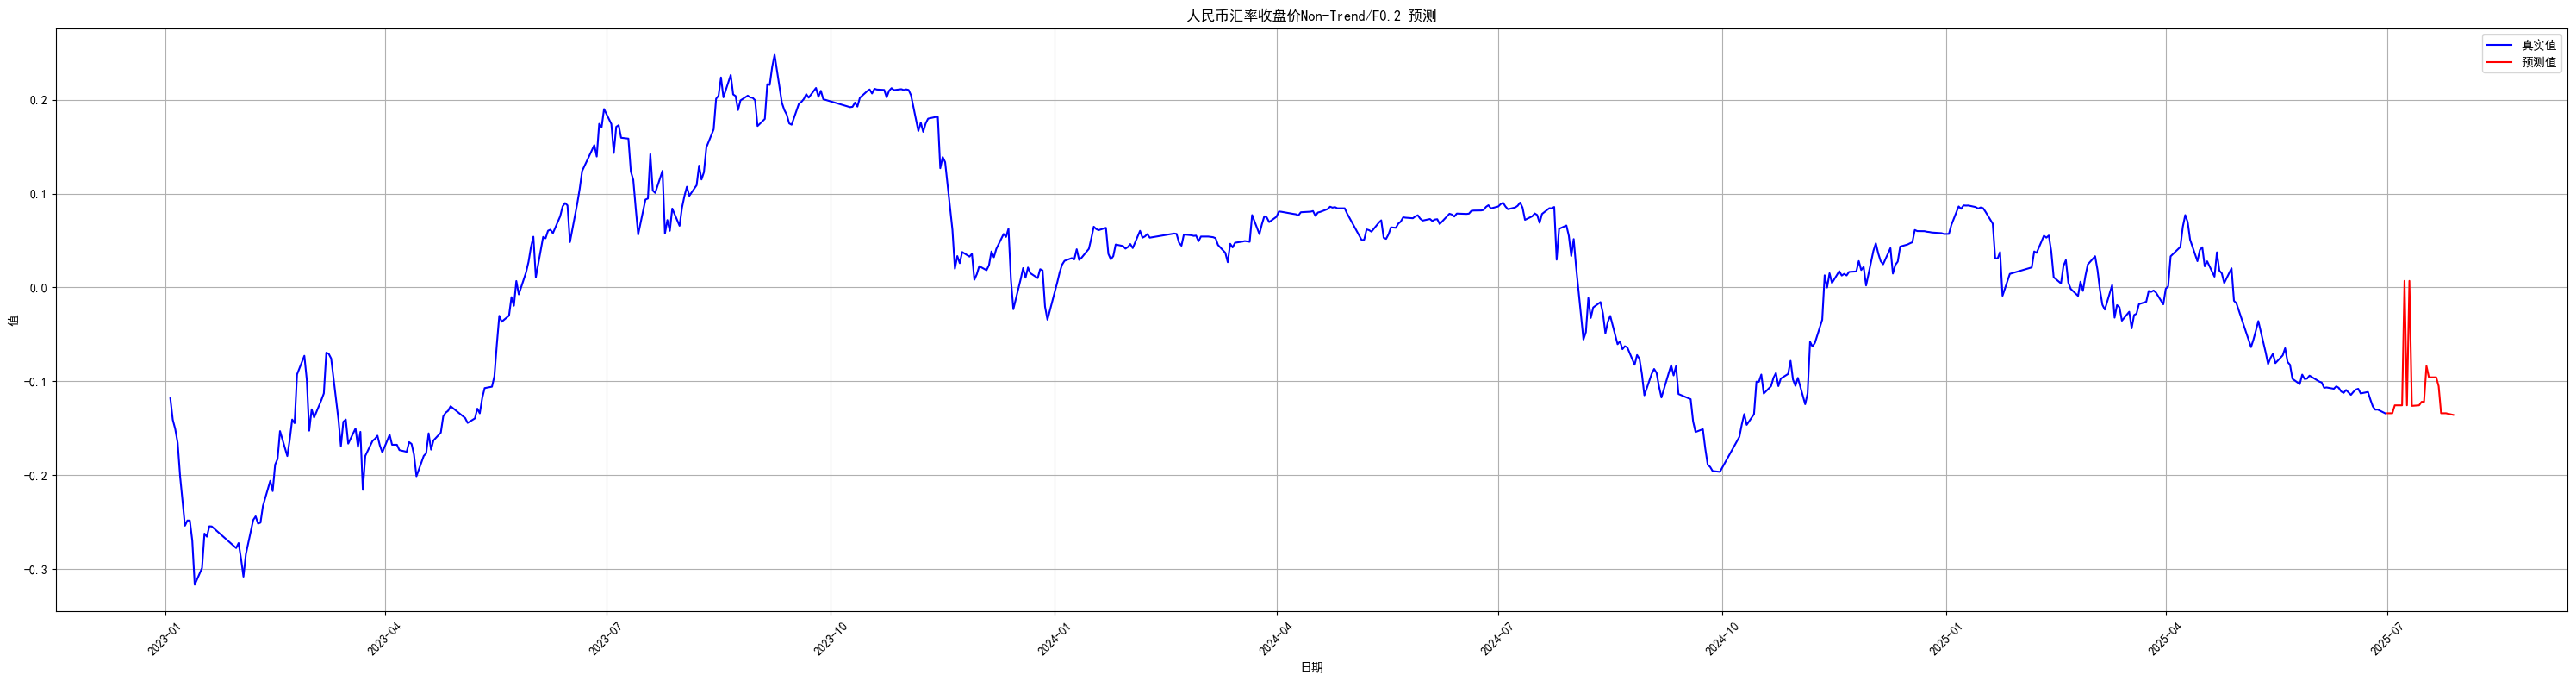

In [20]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily.copy()
# 将日期格式转换回datetime格式用于绘图
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')
# 绘制预测值曲线(红色) 
plt.plot(merged_df_daily_plot['Date'],merged_df_daily_plot['预测值'], color='red', label='预测值')
avline_date = pd.to_datetime(last_day)
plt.legend()
plt.title('人民币汇率收盘价Non-Trend/F0.2 预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:

############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/人民币汇率收盘价Non-Trend_F0.2_月度数据.xlsx', index=False, float_format='%.4f')

In [22]:
sheet_daily.columns

Index(['Date', '人民币汇率收盘价Non-Trend/F0.2', '金融机构外汇存款余额同比', '中国与美国10年国债利差',
       '美元指数', '人民币汇率/收盘-中间', 'SGX UC连1-连13', '金融机构外汇存款余额同比_提前20天',
       '中国与美国10年国债利差_提前20天', '美元指数_提前20天', '人民币汇率/收盘-中间_提前20天',
       'SGX UC连1-连13_提前30天', '金融机构外汇存款余额同比_提前20天_逆序', '中国与美国10年国债利差_提前20天_逆序'],
      dtype='object')

In [23]:
future_data.tail()

,Date,人民币汇率收盘价Non-Trend/F0.2,金融机构外汇存款余额同比,中国与美国10年国债利差,美元指数,人民币汇率/收盘-中间,SGX UC连1-连13,金融机构外汇存款余额同比_提前20天,中国与美国10年国债利差_提前20天,美元指数_提前20天,人民币汇率/收盘-中间_提前20天,SGX UC连1-连13_提前30天,金融机构外汇存款余额同比_提前20天_逆序,中国与美国10年国债利差_提前20天_逆序,预测值,预测值_全量
677,2025-07-22,NaN,0.1897,-2.632731,97.333216,0.007,0.1737,0.1897,-2.6533,97.957200,0.0125,0.1852,0.3133,2.0034,-0.040879,-0.105186
678,2025-07-23,NaN,0.1897,-2.713061,97.541448,0.007,0.1737,0.1897,-2.6393,97.703200,0.0045,0.1837,0.3133,1.9894,-0.079470,-0.134100
679,2025-07-24,NaN,0.1897,-2.738181,97.750683,0.007,0.1737,0.1897,-2.6111,97.307700,0.0064,0.1820,0.3133,1.9612,-0.080553,-0.134100
680,2025-07-25,NaN,0.1897,-2.716551,98.104837,0.007,0.1737,0.1897,-2.6447,97.261600,0.0063,0.1803,0.3133,1.9948,-0.079470,-0.134100
681,2025-07-28,NaN,0.1897,-2.709480,98.017832,0.007,0.1737,0.1897,-2.6366,97.056832,0.0070,0.1843,0.3133,1.9867,-0.081000,-0.135873


---

In [24]:
'''
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "人民币汇率收盘价Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Dcel import update_excel_data\n# 使用示例\nfile_path = "eta/1.宏观经济_数据上传.xlsx"\nsheet_name = "日度数据表"\nidentifier = "人民币汇率收盘价Non-Trend/F0.2"\n\n# 调用函数更新数据\nsuccess = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'